# This Notebook fits MultiLayer Perceptron over All datasets to capture its performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import text, sequence
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow import keras
from normalizer import Normalizer
from results import ModelEvaluation
from joblib import dump

    Let's write some macros for I/O

In [2]:
def print_info(msg):
    print("[INFO] "+str(msg))

def print_err(msg):
    print("[ERR] "+str(msg))

def get_balanced_sample(data_frame, n):
    # Separate the DataFrame into two DataFrames based on class
    class_0_df = data_frame[data_frame['label'] == 0]
    class_1_df = data_frame[data_frame['label'] == 1]

    # Calculate the number of samples for each class in the balanced sample
    n_per_class = n // 2  # Divide by 2 to get an equal number of samples for each class

    # Sample n_per_class random rows from each class
    balanced_sample_class_0 = class_0_df.sample(n=n_per_class, random_state=42)
    balanced_sample_class_1 = class_1_df.sample(n=n_per_class, random_state=42)

    # Combine the balanced samples into a single DataFrame
    balanced_sample = pd.concat([balanced_sample_class_0, balanced_sample_class_1])

    # Shuffle the balanced sample
    balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_sample


def get_combined_datasets(data_frame_one, data_frame_two):
    combined_df = pd.concat([data_frame_one, data_frame_two])

# Step 2: Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
    return shuffled_df

def save_model(model, name):
    dump(model, "../FinalModels/models/"+str(name))

def save_vectorizer(vectorizer, name):
    dump(vectorizer, "../FinalModels/vectorizers/"+str(name))

from sklearn.model_selection import StratifiedKFold
import numpy as np

def perform_stratified_cv(model_fn, X, y, n_splits=5, epochhs=3, batch__size = 64):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if hasattr(X_train, "todense"):
            X_train = X_train.todense()
            X_test = X_test.todense()

        model = model_fn(X_train)

        model.fit(X_train, y_train, epochs=epochhs, batch_size=batch__size)

        scores = model.evaluate(X_test, y_test)
        print(f"Fold {fold + 1}: {scores}")

        fold_scores.append(scores)
        del model
    del X
    del y
    del X_train
    del y_train
    del y_test
    del X_test

    print("Average score across folds:", np.mean(fold_scores, axis=0))

    Initialize some objects that we might need throughout.

In [3]:
normalizer = Normalizer()
results = ModelEvaluation()
SAMPLE_SIZE = 20000
print_info("OBJECTS INIT DONE.")

[INFO] OBJECTS INIT DONE.


    Let's load all the datasets:

In [4]:
TwitterData = pd.read_csv("../FinalModels/datasets/TwitterData.csv")
print_info("Twitter Dataset is now loaded.")

NewsHeadlinesData =  pd.read_csv("../FinalModels/datasets/NewsHeadlines.csv")
print_info("NewHeadlines Dataset is now loaded.")

RedditData = pd.read_csv("../FinalModels/datasets/RedditData.csv")
print_info("Reddit Dataset is now loaded.")

TwitterNewsData = pd.read_csv("../FinalModels/datasets/TwitterNews.csv")
print_info("Twitter News data is now loaded.")

CombinedData = pd.read_csv("../FinalModels/datasets/Twitter_News_Reddit.csv")
print_info("The combined dataset is now loaded.")


[INFO] Twitter Dataset is now loaded.
[INFO] NewHeadlines Dataset is now loaded.
[INFO] Reddit Dataset is now loaded.
[INFO] Twitter News data is now loaded.
[INFO] The combined dataset is now loaded.


# 1. Logistic Regression for News Headlines Dataset:

In [5]:
news_matrix = normalizer.vectorize(pd.DataFrame({"text": NewsHeadlinesData["text"].astype("str")}))
print_info("Here's the sprase matrix info: ")
news_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.
[INFO] Here's the sprase matrix info: 


<20000x22618 sparse matrix of type '<class 'numpy.float64'>'
	with 191328 stored elements in Compressed Sparse Row format>

In [6]:
print_info("Attempting to split data into train and test sets.")
y_news = NewsHeadlinesData["label"].astype("int")
X_news = news_matrix.toarray()
X_news_train, X_news_test, y_news_train, y_news_test = train_test_split(X_news, y_news, test_size=0.20, random_state=42, stratify=y_news)
X_news_train, X_news_val, y_news_train, y_news_val = train_test_split(X_news_train, y_news_train, test_size=0.10, random_state=42, stratify=y_news_train)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


    Lets define the model architecture:

In [7]:
def Create_MultiLayerNetwrok(train):

    mlp = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    mlp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return mlp


In [8]:
mlp_news = Create_MultiLayerNetwrok(X_news)
print_info(mlp_news.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5790464   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5840001 (22.28 MB)
Trainable params: 5840001 (22.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
[INFO] None


In [9]:
history = mlp_news.fit(X_news_train, y_news_train, epochs=2, batch_size=128, validation_data=(X_news_val, y_news_val))


Epoch 1/2
113/113 [==============================] - 4s 33ms/step - loss: 0.5281 - accuracy: 0.7374 - val_loss: 0.4054 - val_accuracy: 0.8138
Epoch 2/2
113/113 [==============================] - 3s 31ms/step - loss: 0.2577 - accuracy: 0.8982 - val_loss: 0.4185 - val_accuracy: 0.8194


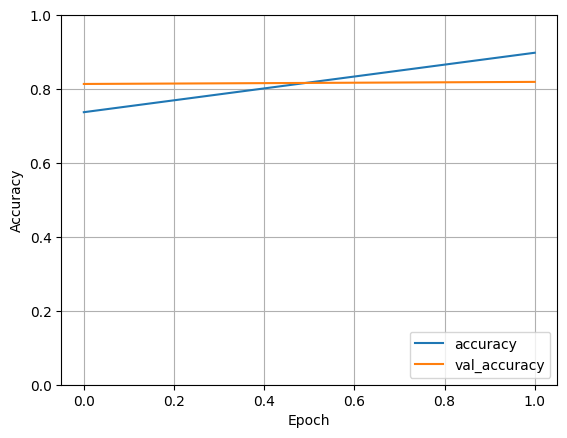

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

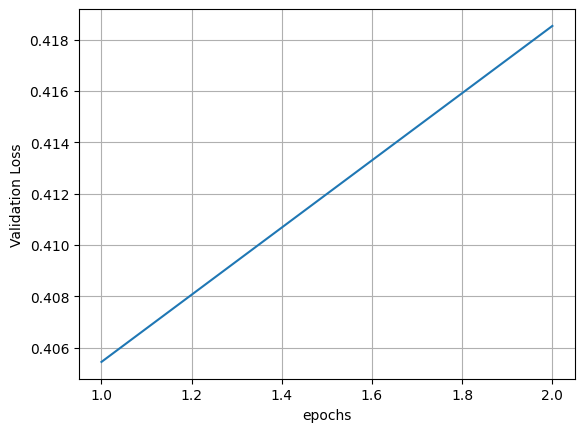

In [11]:
losses = history.history["val_loss"]
plt.plot(range(1,3), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [12]:
y_pred_news = mlp_news.predict(X_news_test)

y_pred_class = (y_pred_news >= 0.5).astype(int)
results.classification_report(y_news_test, y_pred_class)

125/125 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2000
           1       0.84      0.86      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



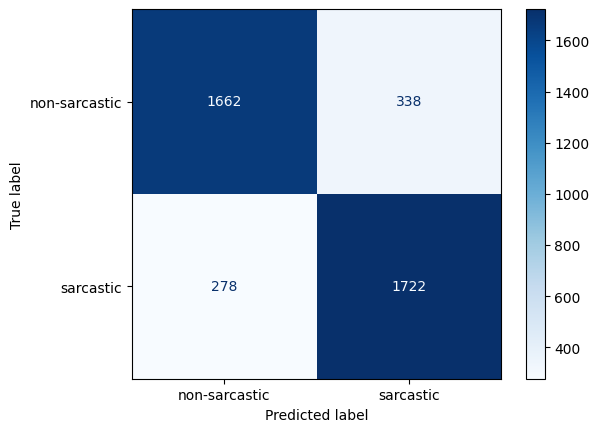

In [13]:
results.get_cm(y_true=y_news_test, y_pred=y_pred_class)

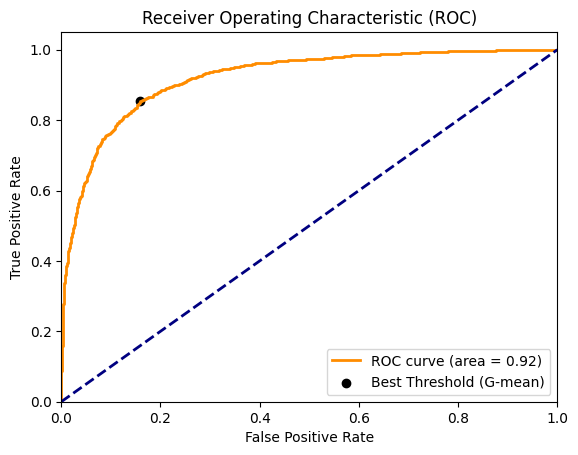

Best Threshold=0.5287


In [14]:

news_threshold = results.get_roc(y_news_test, y_pred_news)

In [15]:
y_pred_class = (y_pred_news >= news_threshold).astype(int)
results.classification_report(y_news_test, y_pred_class)

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2000
           1       0.84      0.85      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



In [16]:
perform_stratified_cv(Create_MultiLayerNetwrok, X_news, y_news, 5, 2, 128)

Epoch 1/2
125/125 [==============================] - 5s 36ms/step - loss: 0.5132 - accuracy: 0.7489
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.3866 - accuracy: 0.8320
Fold 1: [0.38656696677207947, 0.8320000171661377]
Epoch 1/2
125/125 [==============================] - 4s 32ms/step - loss: 0.5180 - accuracy: 0.7404
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.3807 - accuracy: 0.8347
Fold 2: [0.38067135214805603, 0.8347499966621399]
Epoch 1/2
125/125 [==============================] - 4s 33ms/step - loss: 0.5166 - accuracy: 0.7555
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.3901 - accuracy: 0.8322
Fold 3: [0.3900538980960846, 0.8322499990463257]
Epoch 1/2
125/125 [==============================] - 5s 33ms/step - loss: 0.5149 - accuracy: 0.7462
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.4166 - accuracy: 0.8260
Fold 4: [0.41658738255500793, 0.8259999752044678]
Epoch

In [17]:
#Let's save this model:
mlp_news.save("../FinalModels/models/NewsHeadlines_MLP.h5")

c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 2. Multi-Layer Perceptron over Twitter Data:

In [18]:
twitter_matrix = normalizer.vectorize(pd.DataFrame({"text": TwitterData["text"].astype("str")}))
twitter_vectorizer = normalizer.get_vertorizer()
dump(twitter_vectorizer,"../FinalModels/vectorizers/Twitter_LR_Vectorizer.joblib")
print_info("Here's the sprase matrix info: ")
twitter_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.
[INFO] Here's the sprase matrix info: 


<20000x22191 sparse matrix of type '<class 'numpy.float64'>'
	with 276871 stored elements in Compressed Sparse Row format>

In [19]:
print_info("Attempting to split data into train and test sets.")
y_twitter = TwitterData["label"].astype("int")
X_twitter = twitter_matrix.toarray()
X_twitter_train, X_twitter_test, y_twitter_train, y_twitter_test = train_test_split(X_twitter, y_twitter, test_size=0.20, random_state=42, stratify=y_twitter)
X_twitter_train, X_twitter_val, y_twitter_train, y_twitter_val = train_test_split(X_twitter_train, y_twitter_train, test_size=0.10, random_state=42, stratify=y_twitter_train)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


In [20]:
mlp_twitter = Create_MultiLayerNetwrok(X_twitter_train)
print_info(mlp_twitter.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               5681152   
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5730689 (21.86 MB)
Trainable params: 5730689 (21.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
[INFO] None


In [21]:
history = mlp_twitter.fit(X_twitter_train, y_twitter_train, epochs=2, batch_size=128, validation_data=(X_twitter_val, y_twitter_val))


Epoch 1/2
113/113 [==============================] - 5s 36ms/step - loss: 0.6147 - accuracy: 0.6664 - val_loss: 0.4881 - val_accuracy: 0.7694
Epoch 2/2
113/113 [==============================] - 4s 32ms/step - loss: 0.4073 - accuracy: 0.8241 - val_loss: 0.4580 - val_accuracy: 0.7881


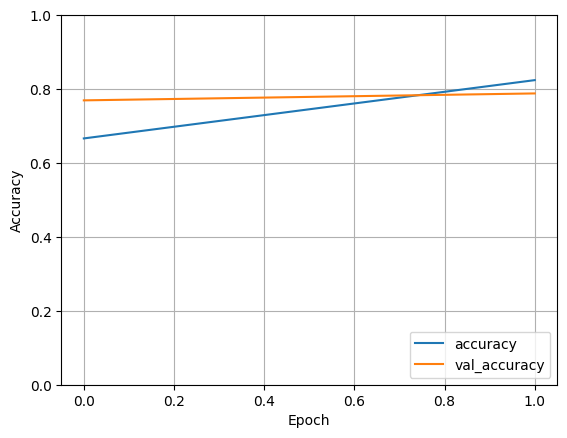

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

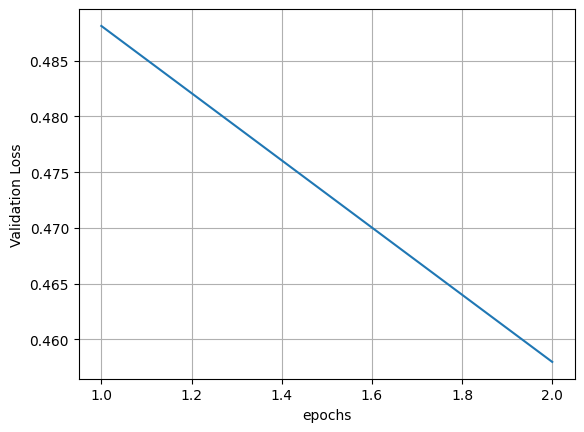

In [23]:
losses = history.history["val_loss"]
plt.plot(range(1,3), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [24]:
y_twitter_pred = mlp_twitter.predict(X_twitter_test)

y_pred_class = (y_twitter_pred >= 0.5).astype(int)
results.classification_report(y_twitter_test, y_pred_class)

125/125 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2000
           1       0.81      0.73      0.77      2000

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



[INFO] The following the confusion matirx for Naive Bayes over Twitter Test Set:


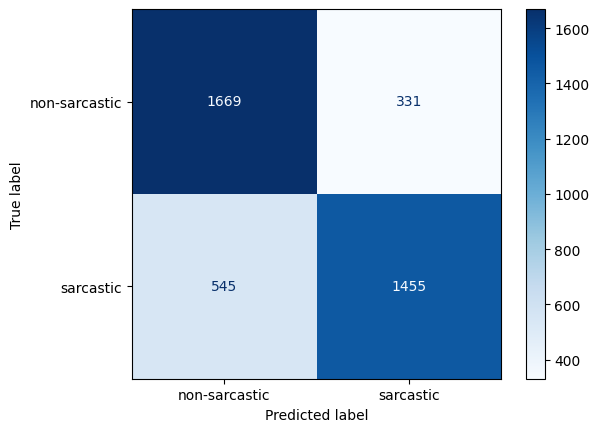

In [25]:
print_info("The following the confusion matirx for Naive Bayes over Twitter Test Set:")
results.get_cm(y_twitter_test, y_pred_class)

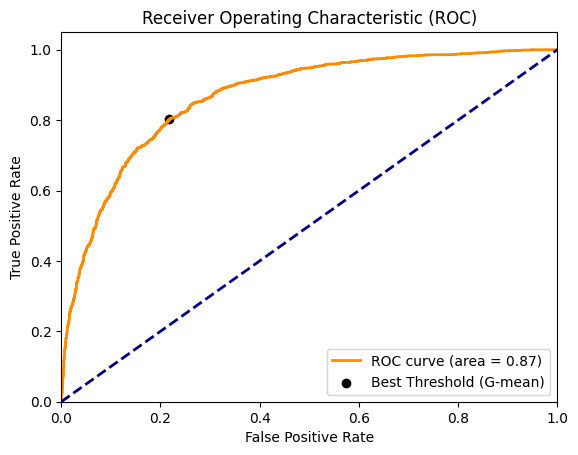

Best Threshold=0.3858


In [26]:
twitter_threshold = results.get_roc(y_twitter_test, y_twitter_pred)

In [27]:
perform_stratified_cv(Create_MultiLayerNetwrok, X_twitter, y_twitter, 5, 2, 128)

Epoch 1/2
125/125 [==============================] - 4s 32ms/step - loss: 0.6120 - accuracy: 0.6679
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.4524 - accuracy: 0.7908
Fold 1: [0.4523976445198059, 0.7907500267028809]
Epoch 1/2
125/125 [==============================] - 4s 33ms/step - loss: 0.5952 - accuracy: 0.6855
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.4877 - accuracy: 0.7757
Fold 2: [0.4877423346042633, 0.7757499814033508]
Epoch 1/2
125/125 [==============================] - 5s 35ms/step - loss: 0.6091 - accuracy: 0.6696
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.4920 - accuracy: 0.7750
Fold 3: [0.4919505715370178, 0.7749999761581421]
Epoch 1/2
125/125 [==============================] - 5s 33ms/step - loss: 0.5933 - accuracy: 0.6830
Epoch 2/2
125/125 [==============================] - 1s 4ms/step - loss: 0.4852 - accuracy: 0.7788
Fold 4: [0.48524442315101624, 0.7787500023841858]
Epoch 1

In [28]:
#save the model:
mlp_twitter.save("../FinalModels/models/Twitter_MLP.h5")

c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 3. Multi-Layer Perceptron over Reddit set:

In [29]:
reddit_matrix = normalizer.vectorize(pd.DataFrame({"text": RedditData["text"].astype("str")}))
reddit_vectorizer = normalizer.get_vertorizer()
dump(reddit_vectorizer,"../FinalModels/vectorizers/Reddit_NB_Vectorizer.joblib")
print_info("Here's the sprase matrix info: ")
reddit_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.
[INFO] Here's the sprase matrix info: 


<20000x41893 sparse matrix of type '<class 'numpy.float64'>'
	with 533494 stored elements in Compressed Sparse Row format>

In [30]:
print_info("Attempting to split data into train and test sets.")
y_reddit = RedditData["label"].astype("int")
X_reddit = reddit_matrix.toarray()
X_reddit_train, X_reddit_test, y_reddit_train, y_reddit_test = train_test_split(X_reddit, y_reddit, test_size=0.20, random_state=42, stratify=y_reddit)
X_reddit_train, X_reddit_val, y_reddit_train, y_reddit_val = train_test_split(X_reddit_train, y_reddit_train, test_size=0.10, random_state=42, stratify=y_reddit_train)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


In [31]:
mlp_reddit =Create_MultiLayerNetwrok(X_reddit)
mlp_reddit.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               10724864  
                                                                 
 dense_49 (Dense)            (None, 128)               32896     
                                                                 
 dense_50 (Dense)            (None, 128)               16512     
                                                                 
 dense_51 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10774401 (41.10 MB)
Trainable params: 10774401 (41.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = mlp_reddit.fit(X_reddit_train, 
                         y_reddit_train, 
                         epochs=2, 
                         batch_size=64, 
                         validation_data=(X_reddit_val, y_reddit_val))

Epoch 1/2
225/225 [==============================] - 13s 55ms/step - loss: 0.6791 - accuracy: 0.5642 - val_loss: 0.6590 - val_accuracy: 0.5969
Epoch 2/2
225/225 [==============================] - 12s 53ms/step - loss: 0.5552 - accuracy: 0.7255 - val_loss: 0.6988 - val_accuracy: 0.5962


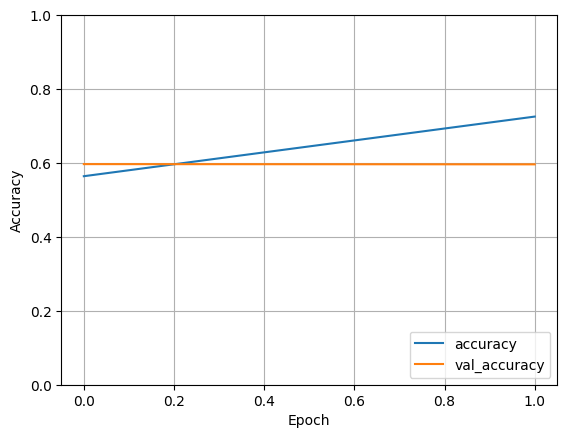

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

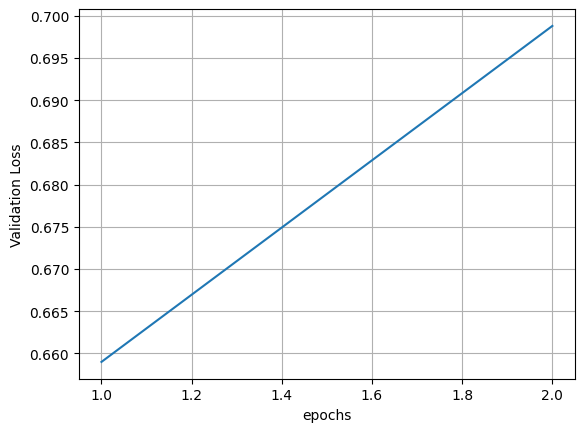

In [34]:
losses = history.history["val_loss"]
plt.plot(range(1,3), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [35]:
y_reddit_pred = mlp_reddit.predict(X_reddit_test)

y_pred_class = (y_reddit_pred >= 0.5).astype(int)
results.classification_report(y_reddit_test, y_pred_class)

125/125 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.63      0.53      0.57      2000
           1       0.59      0.69      0.64      2000

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000



[INFO] The following the confusion matirx for Naive Bayes over Twitter Test Set:


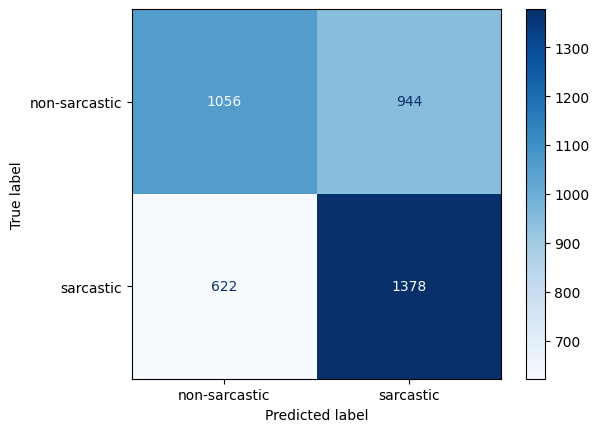

In [36]:
print_info("The following the confusion matirx for Naive Bayes over Twitter Test Set:")
results.get_cm(y_twitter_test, y_pred_class)

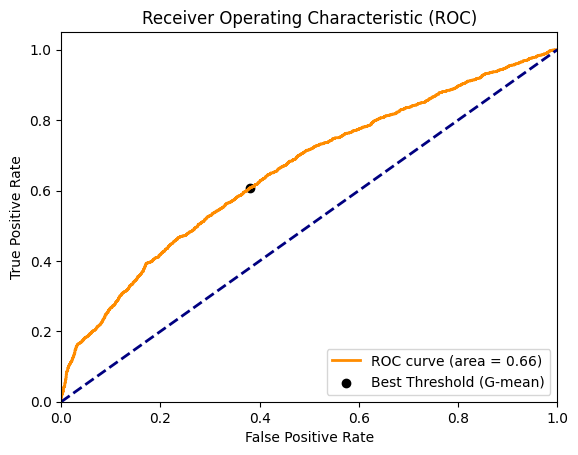

Best Threshold=0.5739


In [37]:
reddit_threshold = results.get_roc(y_reddit_test, y_reddit_pred)

In [38]:
perform_stratified_cv(Create_MultiLayerNetwrok, X_reddit, y_reddit, 5, 2, 128)

Epoch 1/2
125/125 [==============================] - 8s 63ms/step - loss: 0.6892 - accuracy: 0.5362
Epoch 2/2
125/125 [==============================] - 1s 7ms/step - loss: 0.6838 - accuracy: 0.5895
Fold 1: [0.6837865114212036, 0.5895000100135803]
Epoch 1/2
125/125 [==============================] - 8s 58ms/step - loss: 0.6822 - accuracy: 0.5568
Epoch 2/2
125/125 [==============================] - 1s 6ms/step - loss: 0.6752 - accuracy: 0.6020
Fold 2: [0.6752318739891052, 0.6019999980926514]
Epoch 1/2
125/125 [==============================] - 14s 105ms/step - loss: 0.6851 - accuracy: 0.5549
Epoch 2/2
125/125 [==============================] - 1s 8ms/step - loss: 0.6715 - accuracy: 0.6008
Fold 3: [0.6714512705802917, 0.6007500290870667]
Epoch 1/2
125/125 [==============================] - 9s 68ms/step - loss: 0.6880 - accuracy: 0.5403
Epoch 2/2
125/125 [==============================] - 1s 7ms/step - loss: 0.6457 - accuracy: 0.6230
Fold 4: [0.6457119584083557, 0.6230000257492065]
Epoch 

In [39]:
mlp_reddit.save("../FinalModels/models/Reddit_MLP.h5")

c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
